In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import pandas as pd
import umap
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import HomeMade as hm
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
N = 3e5

all_features = "v0_ks_mass v0_ks_massErr pv0_x pv0_y pv0_z a0xy a0 a0z cosTheta v0_chi2 \
v0_x v0_y v0_z v0_rxy v0_rxyErr v0_px v0_py v0_pz v0_pt v0_p \
v0_ptErr ntrk_pv0 \
v0_px1 v0_py1 v0_pz1 v0_pt1 \
v0_p1 v0_px2 v0_py2 v0_pz2 v0_pt2 v0_p2 v0_phi1 v0_theta1 \
v0_qOverP1 v0_phi2 v0_theta2 v0_qOverP2 alpha calpha epsilon1 \
epsilon2 Alpha pL1 pL2 pT thetastar rapidity_ks pseudorapidity".split(" ")

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(all_features, entrystop = N) #was run with 1e7

path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(all_features + ['trueKs'], entrystop = N)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]
mc = mc.loc[(mc.v0_ks_mass > 400) & (mc.v0_ks_mass < 600)].reset_index(drop=True)

In [3]:
#For testing i will only work in mc and then later try it in data:
split = int(len(mc)/3)
train_umap = mc[:split]
train = mc[split:2*split]
test = mc[2*split:]

Define nessecary algorithms and split features

In [24]:
xgb_feats = "v0_chi2 v0_px1 v0_phi1 v0_py1 v0_py v0_py2 v0_phi2 v0_px2 v0_px".split(" ") #AUC as xgbclassifier ~ 0.89765
# xgb_feats = "cosTheta a0xy a0 v0_y v0_x v0_rxyErr v0_z pv0_z pv0_y ntrk_pv0 pv0_x".split(" ") #AUC as xgbclassifier ~ 0.99676

In [25]:
scaler = StandardScaler()
cla = xgb.XGBClassifier()
cla_nomap = xgb.XGBClassifier() #Scaling before cla_nomap has no effect, atleast with good xgb_feats
yumap = umap.UMAP(n_components = len(xgb_feats))

In [26]:
yumap.fit(scaler.fit_transform(train_umap[xgb_feats]),y=train_umap.trueKs)

cla.fit(StandardScaler().fit_transform(PCA().fit_transform(yumap.transform(scaler.transform(train[xgb_feats])))),y=train.trueKs)
cla_nomap.fit(train[xgb_feats],y=train.trueKs)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

Text(0.5, 1.0, 'Nomap AUC: 0.8509078095789382')

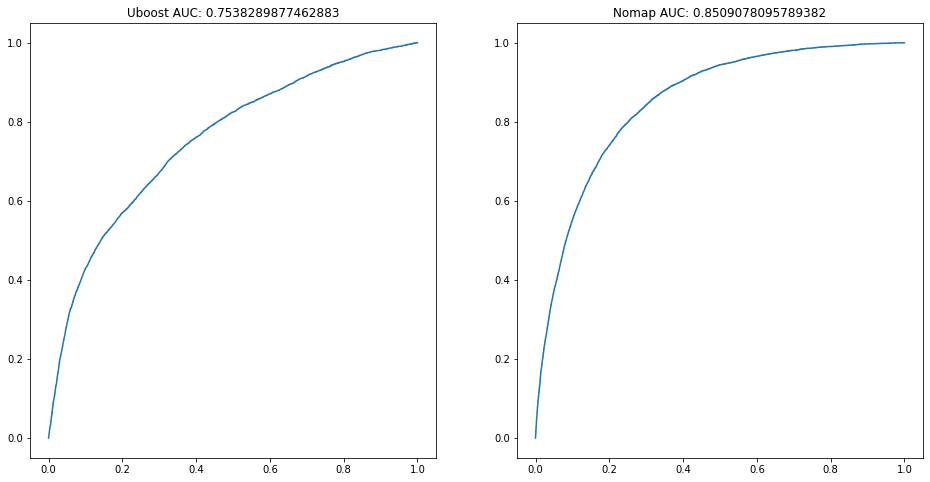

In [61]:
#For testing in MC:
p = cla.predict_proba(StandardScaler().fit_transform(PCA().fit_transform(yumap.transform(scaler.transform(test[xgb_feats])))[:,[0,2,1,4,3,5,6,7,8]]))[:,1]
# p = cla.predict_proba(StandardScaler().fit_transform(PCA().fit_transform(yumap.transform(scaler.transform(test[xgb_feats])))))[:,1]
# p_nomap = cla_nomap.predict_proba(test[xgb_feats])[:,1]

fpr,tpr,t = roc_curve(test.trueKs,p) 
auc = roc_auc_score(test.trueKs,p)
fpr_nomap,tpr_nomap,t_nomap= roc_curve(test.trueKs,p_nomap)
auc_nomap = roc_auc_score(test.trueKs,p_nomap)

fig, ax = plt.subplots(ncols=2,figsize=(16,8))
ax[0].plot(fpr,tpr)
ax[0].set_title(f'Uboost AUC: {auc}')

ax[1].plot(fpr_nomap,tpr_nomap)
ax[1].set_title(f'Nomap AUC: {auc_nomap}')

In [ ]:
perms = [[0,1,2,3,4,5,6,7,8],
         [1,0,3,2,5,4,7,6,8],
         [2,0,1,4,3,6,5,7,8],
         [2,1,0,4,5,3,7,8,6]
        ]


In [51]:
emb = yumap.transform(scaler.transform(test[xgb_feats]))

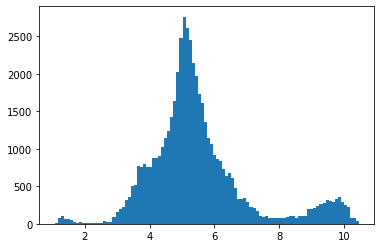

In [54]:
plt.hist(emb[:,2],bins=100);

In [29]:
emb = PCA().fit_transform(yumap.transform(scaler.transform(train[xgb_feats])))

0 2.7741456
1 2.242119
2 1.7642592
3 1.0181015
4 0.6280682
5 0.38378966
6 0.35585168
7 0.26957667
8 0.1322933


IndexError: index 9 is out of bounds for axis 1 with size 9

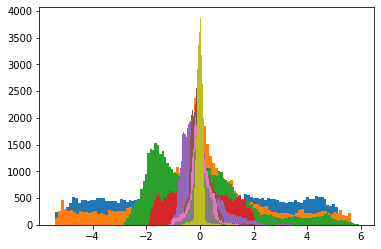

In [45]:
for i in range(9):
    plt.hist(emb[:,i],bins=100);
    print(i,emb[:,i].std())